# Using quadratic approximation and MCMC for the !Kung adults' height

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm, multivariate_normal

import pymc as pm
import arviz as az

In [2]:
ALPHA = 0.11

Data

In [3]:
dat = pd.read_csv('Data/Howell1.csv', sep=';')
dat_adults = dat[dat['age'] >= 18].reset_index(drop=True) # We are interested in adult's height

Fit the model and sample from the prior.

In [4]:
with pm.Model() as ModelHeight:
    mu      = pm.Normal('mu', mu=170, sigma=10)
    sigma   = pm.Uniform('sigma', lower=0, upper=33)
    height  = pm.Normal('height', mu=mu, sigma=sigma, observed=dat_adults['height'])

    TraceHeight = pm.sample_prior_predictive()

Sampling: [height, mu, sigma]


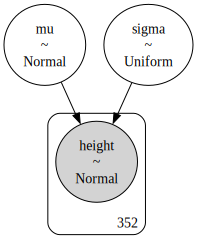

In [5]:
pm.model_to_graphviz(ModelHeight)

Check the prior

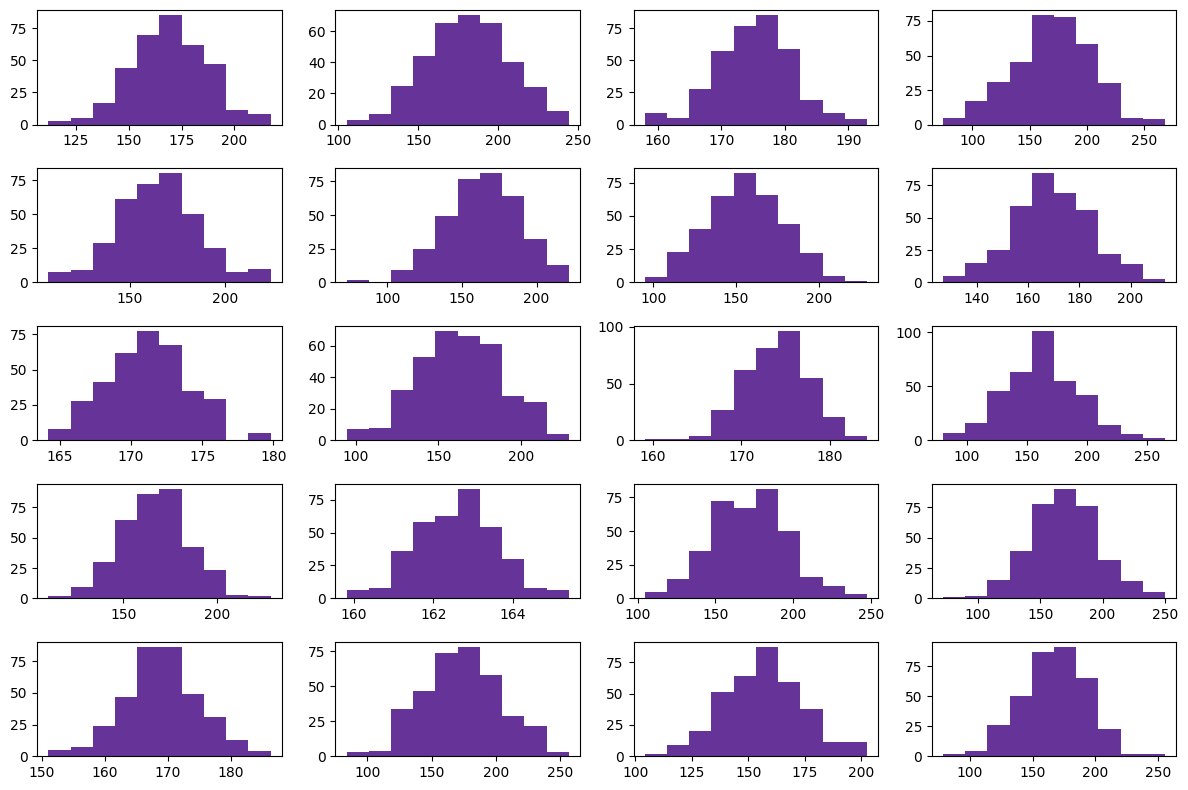

In [6]:
fig, axs = plt.subplots(figsize=(12, 8), ncols=4, nrows=5)

ind = 0
for j in range(5):
    for k in range(4):
        axs[j, k].hist(TraceHeight.prior_predictive.height[0][ind], color='rebeccapurple')
        ind = ind + 1
        
fig.tight_layout()

## Using the normal approximation.

In [7]:
with ModelHeight:
    MeanQ  = pm.find_MAP()

with pm.Model() as ModelHeight2:
    mu      = pm.Normal('mu', mu=170, sigma=10, transform=None)
    sigma   = pm.Uniform('sigma', lower=0, upper=33, transform=None)
    height  = pm.Normal('height', mu=mu, sigma=sigma, observed=dat_adults['height'], transform=None)

    IFisher = pm.find_hessian(MeanQ, vars=[mu, sigma])

IFisherInverse = np.linalg.inv(IFisher)

Sample from the approximate normal posterior.

In [8]:
PosteriorSample = multivariate_normal.rvs(
    size=10**3,
    mean=np.array([MeanQ['mu'], MeanQ['sigma']]),
    cov=IFisherInverse
    )

PosteriorSample = pd.DataFrame(PosteriorSample, columns=['mu', 'sigma'])

Text(0, 0.5, '$\\sigma$')

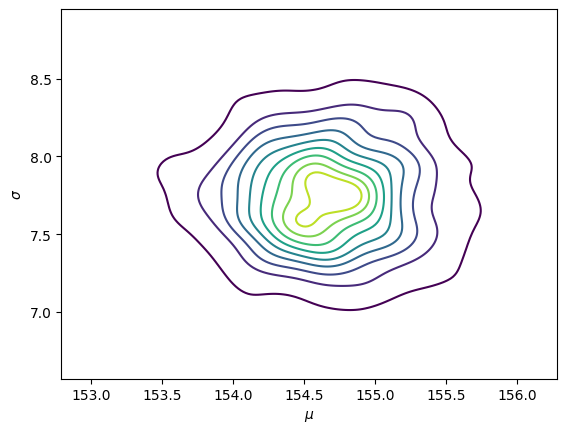

In [9]:
fig, ax = plt.subplots()
sns.kdeplot(x=PosteriorSample['mu'], y=PosteriorSample['sigma'], cmap=plt.cm.viridis, ax=ax, n_levels=10)
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\sigma$')

Posterior interval of $1-\alpha$ of probability.

In [10]:
PosteriorSample.quantile([ALPHA/2, 1-ALPHA/2])

,mu,sigma
0.055,153.99843,7.296303
0.945,155.30353,8.216435


Sample from the posterior predictive.

In [11]:
HeightPosterior = norm.rvs(size=len(PosteriorSample), loc=PosteriorSample['mu'], scale=PosteriorSample['sigma'])

Posterior predictive interval of $1-\alpha$ of probability.

In [12]:
np.quantile(HeightPosterior, [ALPHA/2, 1-ALPHA/2])

array([142.70071573, 167.42549194])

## Using MCMC

In [13]:
with ModelHeight:
    TraceHeight.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

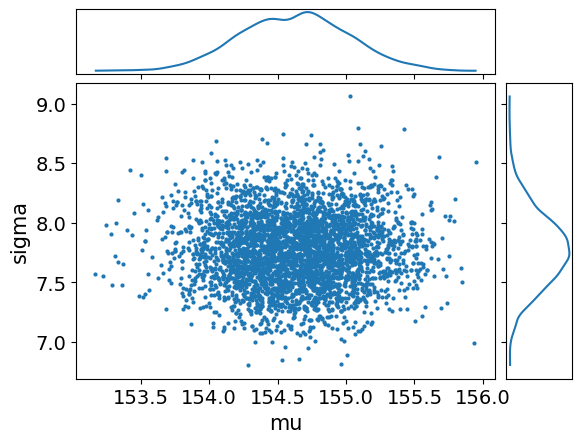

In [14]:
az.plot_pair(TraceHeight, marginals=True)

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

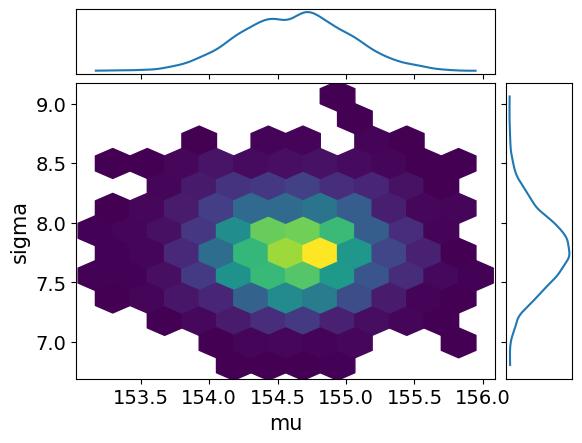

In [15]:
az.plot_pair(TraceHeight, kind="hexbin", marginals=True)

In [16]:
az.summary(TraceHeight, hdi_prob=1-ALPHA, kind='stats')

,mean,sd,hdi_5.5%,hdi_94.5%
mu,154.624,0.405,153.954,155.234
sigma,7.771,0.295,7.258,8.198


Sample from the predictive posterior

In [17]:
with ModelHeight:
    TraceHeight.extend(pm.sample_posterior_predictive(TraceHeight))

Sampling: [height]


Plot the posterior predictive

<Axes: xlabel='height / height'>

/usr/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


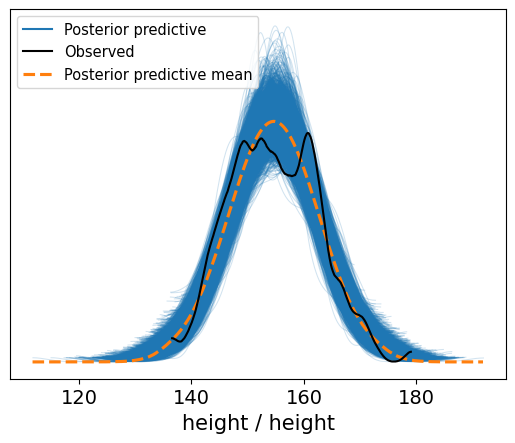

In [18]:
az.plot_ppc(TraceHeight)

We check the posterior predictive for each observation

In [19]:
PosteriorPredictiveSummary = az.summary(TraceHeight, group='posterior_predictive', hdi_prob=1-ALPHA, kind='stats')

In [20]:
dat_adults['height_predict'] = PosteriorPredictiveSummary['mean'].values
dat_adults['height_lpi'] = PosteriorPredictiveSummary['hdi_' + str((ALPHA/2)*100)  + '%'].values
dat_adults['height_upi'] = PosteriorPredictiveSummary['hdi_' + str((1-ALPHA/2)*100)  + '%'].values

Text(0, 0.5, '89.0% hightest posterior density for each $y$')

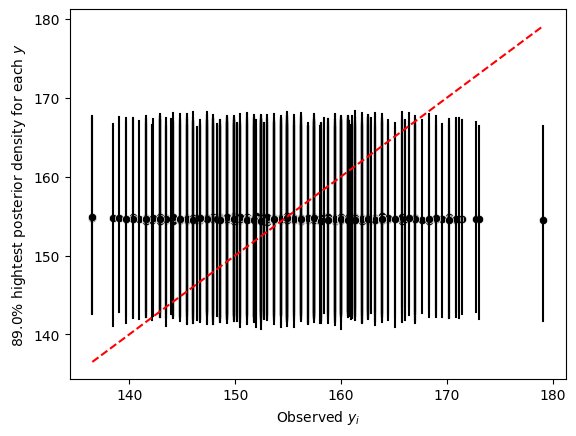

In [21]:
sns.scatterplot(data=dat_adults, x='height', y='height_predict', color='k')

for i in range(len(dat_adults)):
    plt.plot(
        [dat_adults['height'][i], dat_adults['height'][i]],
        [
            dat_adults['height_lpi'][i],
            dat_adults['height_upi'][i]
        ],
        color='k'
    )
    
plt.plot([dat_adults['height'].min(), dat_adults['height'].max()],
         [dat_adults['height'].min(), dat_adults['height'].max()],
         color='r', linestyle='--')

plt.xlabel(r"Observed $y_i$")
plt.ylabel(str((1-ALPHA)*100) + r"% hightest posterior density for each $y$")

We check if the model can explain the quantiles associated with the observations

In [22]:
dat_adults = dat_adults.sort_values('height').reset_index(drop=True)

In [23]:
dat_adults['height_predict_quantile'] = None
dat_adults['height_quantile_lpi']     = None
dat_adults['height_quantile_upi']     = None

for i in range(len(dat_adults)):
    Quantile = np.quantile(TraceHeight.posterior_predictive.height.values, q=i/(len(dat_adults)+1), axis=2).ravel()
    dat_adults.loc[i, 'height_predict_quantile'] = Quantile.mean()
    dat_adults.loc[i, 'height_quantile_lpi'] = np.quantile(Quantile, ALPHA/2)
    dat_adults.loc[i, 'height_quantile_upi'] = np.quantile(Quantile, 1-ALPHA/2)

Text(0, 0.5, '89.0% posterior interval for the order statistic $y_{(i)}$')

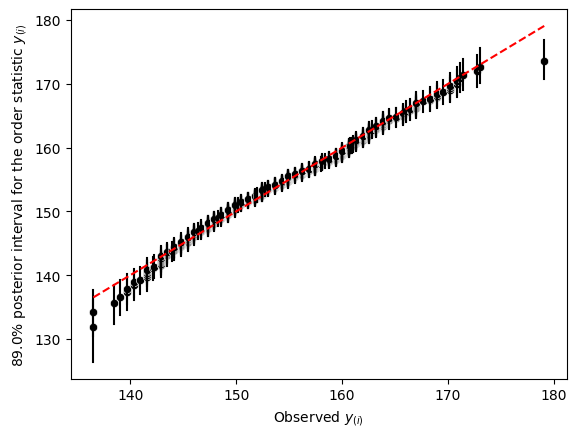

In [24]:
sns.scatterplot(data=dat_adults, x='height', y='height_predict_quantile', color='k')

for i in range(len(dat_adults)):
    plt.plot(
        [dat_adults['height'][i], dat_adults['height'][i]],
        [
            dat_adults['height_quantile_lpi'][i],
            dat_adults['height_quantile_upi'][i]
        ],
        color='k'
    )
    
plt.plot([dat_adults['height'].min(), dat_adults['height'].max()],
         [dat_adults['height'].min(), dat_adults['height'].max()],
         color='r', linestyle='--')

plt.xlabel(r"Observed $y_{(i)}$")
plt.ylabel(str((1-ALPHA)*100) + r"% posterior interval for the order statistic $y_{(i)}$")